## 房价预测

In [47]:
import pandas as pd
import tensorflow as tf
import numpy as np
from tensorflow.python.framework import ops

In [48]:
ops.reset_default_graph()

#### 观察数据

In [49]:
#对结果影响很小,或者与其他特征相关性较高的特征将被丢弃
to_drop = ['Id','Street','Utilities','Condition2','PoolArea','PoolQC','Fence',
           'YrSold','MoSold','BsmtHalfBath','BsmtFinSF2','GarageQual','MiscVal'
           ,'EnclosedPorch','3SsnPorch','GarageArea','TotRmsAbvGrd','GarageYrBlt'
           ,'BsmtFinType2','BsmtUnfSF','GarageCond'
           ,'GarageFinish','FireplaceQu','BsmtCond','BsmtQual','Alley']

In [50]:
price_norm_factor = 10000

In [51]:
def load_data(path):
    data = pd.read_csv(path)
    #填充None值,因为在特征说明中,None也是某些特征的一个值,所以对于这部分特征的缺失值以None填充
    fill_none = ['MasVnrType','BsmtExposure','GarageType','MiscFeature']
    for col in fill_none:
        data[col].fillna('None',inplace=True);
        
#     #LotFrontage 使用平均数填充
#     mean_LotFrontage = data.mean()['LotFrontage'] 
#     print(mean_LotFrontage)
#     data['LotFrontage'].fillna(mean_LotFrontage,inplace=True)#{'LotFrontage':mean_LotFrontage}

    #对其他缺失值进行填充,离散型特征填充众数,数值型特征填充均值
    na_col = data.dtypes[data.isnull().any()];
    print(na_col)
    for col in na_col.index:
        if na_col[col] != 'object':
            med = data[col].mean();
            print(med)
            data[col].fillna(med,inplace=True);
        else:
            mode = data[col].mode()[0];
            print(mode)
            data[col].fillna(mode,inplace=True);
            
    data['SalePrice'] = data['SalePrice'] / price_norm_factor
    
    return data.drop(to_drop,axis=1)

In [52]:
train = load_data('./data/train.csv')

LotFrontage     float64
Alley            object
MasVnrArea      float64
BsmtQual         object
BsmtCond         object
BsmtFinType1     object
BsmtFinType2     object
Electrical       object
FireplaceQu      object
GarageYrBlt     float64
GarageFinish     object
GarageQual       object
GarageCond       object
PoolQC           object
Fence            object
dtype: object
70.04995836802665
Grvl
103.68526170798899
TA
TA
Unf
Unf
SBrkr
Gd
1978.5061638868744
Unf
TA
TA
Gd
MnPrv


In [53]:
train.head(10)

,MSSubClass,MSZoning,LotFrontage,LotArea,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageCars,PavedDrive,WoodDeckSF,OpenPorchSF,ScreenPorch,MiscFeature,SaleType,SaleCondition,SalePrice
0,60,RL,65.000000,8450,Reg,Lvl,Inside,Gtl,CollgCr,Norm,...,Attchd,2,Y,0,61,0,None,WD,Normal,20.85
1,20,RL,80.000000,9600,Reg,Lvl,FR2,Gtl,Veenker,Feedr,...,Attchd,2,Y,298,0,0,None,WD,Normal,18.15
2,60,RL,68.000000,11250,IR1,Lvl,Inside,Gtl,CollgCr,Norm,...,Attchd,2,Y,0,42,0,None,WD,Normal,22.35
3,70,RL,60.000000,9550,IR1,Lvl,Corner,Gtl,Crawfor,Norm,...,Detchd,3,Y,0,35,0,None,WD,Abnorml,14.00
4,60,RL,84.000000,14260,IR1,Lvl,FR2,Gtl,NoRidge,Norm,...,Attchd,3,Y,192,84,0,None,WD,Normal,25.00
5,50,RL,85.000000,14115,IR1,Lvl,Inside,Gtl,Mitchel,Norm,...,Attchd,2,Y,40,30,0,Shed,WD,Normal,14.30
6,20,RL,75.000000,10084,Reg,Lvl,Inside,Gtl,Somerst,Norm,...,Attchd,2,Y,255,57,0,None,WD,Normal,30.70
7,60,RL,70.049958,10382,IR1,Lvl,Corner,Gtl,NWAmes,PosN,...,Attchd,2,Y,235,204,0,Shed,WD,Normal,20.00
8,50,RM,51.000000,6120,Reg,Lvl,Inside,Gtl,OldTown,Artery,...,Detchd,2,Y,90,0,0,None,WD,Abnorml,12.99
9,190,RL,50.000000,7420,Reg,Lvl,Corner,Gtl,BrkSide,Artery,...,Attchd,1,Y,0,4,0,None,WD,Normal,11.80


In [54]:
train_describe = train.describe()
train_describe

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,TotalBsmtSF,...,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,Fireplaces,GarageCars,WoodDeckSF,OpenPorchSF,ScreenPorch,SalePrice
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.00000
mean,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,1057.429452,...,1.565068,0.382877,2.866438,1.046575,0.613014,1.767123,94.244521,46.660274,15.060959,18.09212
std,42.300571,22.024023,9981.264932,1.382997,1.112799,30.202904,20.645407,180.569112,456.098091,438.705324,...,0.550916,0.502885,0.815778,0.220338,0.644666,0.747315,125.338794,66.256028,55.757415,7.94425
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.49000
25%,20.000000,60.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,795.750000,...,1.000000,0.000000,2.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,12.99750
50%,50.000000,70.049958,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,991.500000,...,2.000000,0.000000,3.000000,1.000000,1.000000,2.000000,0.000000,25.000000,0.000000,16.30000
75%,70.000000,79.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,164.250000,712.250000,1298.250000,...,2.000000,1.000000,3.000000,1.000000,1.000000,2.000000,168.000000,68.000000,0.000000,21.40000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,6110.000000,...,3.000000,2.000000,8.000000,3.000000,3.000000,4.000000,857.000000,547.000000,480.000000,75.50000


### 计算相关性 大于0 表示正相关，小于0表示负相关

In [55]:
train_corr = train.corr()
train_corr

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,TotalBsmtSF,...,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,Fireplaces,GarageCars,WoodDeckSF,OpenPorchSF,ScreenPorch,SalePrice
MSSubClass,1.000000,-0.357056,-0.139781,0.032628,-0.059316,0.027850,0.040581,0.022895,-0.069836,-0.238518,...,0.131608,0.177354,-0.023438,0.281721,-0.045569,-0.040110,-0.012579,-0.006100,-0.026030,-0.084284
LotFrontage,-0.357056,1.000000,0.306795,0.234196,-0.052820,0.117598,0.082746,0.179283,0.215828,0.363358,...,0.180424,0.048258,0.237023,-0.005805,0.235755,0.269729,0.077106,0.137454,0.037684,0.334901
LotArea,-0.139781,0.306795,1.000000,0.105806,-0.005636,0.014228,0.013788,0.103960,0.214103,0.260833,...,0.126031,0.014259,0.119690,-0.017784,0.271364,0.154871,0.171698,0.084774,0.043160,0.263843
OverallQual,0.032628,0.234196,0.105806,1.000000,-0.091932,0.572323,0.550684,0.410238,0.239666,0.537808,...,0.550600,0.273458,0.101676,-0.183882,0.396765,0.600671,0.238923,0.308819,0.064886,0.790982
OverallCond,-0.059316,-0.052820,-0.005636,-0.091932,1.000000,-0.375983,0.073741,-0.127788,-0.046231,-0.171098,...,-0.194149,-0.060769,0.012980,-0.087001,-0.023820,-0.185758,-0.003334,-0.032589,0.054811,-0.077856
YearBuilt,0.027850,0.117598,0.014228,0.572323,-0.375983,1.000000,0.592855,0.314745,0.249503,0.391452,...,0.468271,0.242656,-0.070651,-0.174800,0.147716,0.537850,0.224880,0.188686,-0.050364,0.522897
YearRemodAdd,0.040581,0.082746,0.013788,0.550684,0.073741,0.592855,1.000000,0.179186,0.128451,0.291066,...,0.439046,0.183331,-0.040581,-0.149598,0.112581,0.420622,0.205726,0.226298,-0.038740,0.507101
MasVnrArea,0.022895,0.179283,0.103960,0.410238,-0.127788,0.314745,0.179186,1.000000,0.263582,0.362452,...,0.275730,0.200802,0.102417,-0.037364,0.247906,0.363778,0.159349,0.124965,0.061453,0.475241
BsmtFinSF1,-0.069836,0.215828,0.214103,0.239666,-0.046231,0.249503,0.128451,0.263582,1.000000,0.522396,...,0.058543,0.004262,-0.107355,-0.081007,0.260011,0.224054,0.204306,0.111761,0.062021,0.386420
TotalBsmtSF,-0.238518,0.363358,0.260833,0.537808,-0.171098,0.391452,0.291066,0.362452,0.522396,1.000000,...,0.323722,-0.048804,0.050450,-0.068901,0.339519,0.434585,0.232019,0.247264,0.084489,0.613581


In [56]:
import seaborn as sns
import matplotlib.pyplot as plt

In [57]:
%matplotlib inline

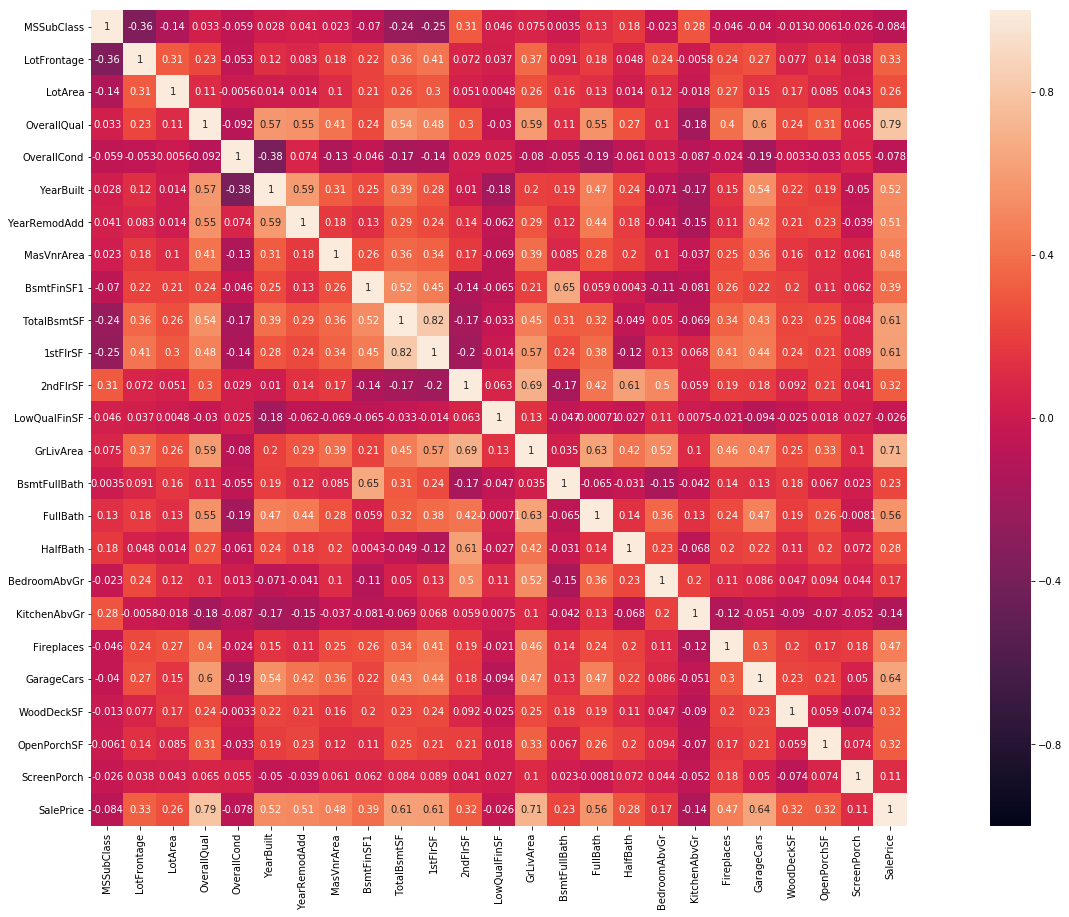

In [58]:
#画出相关性热力图
a = plt.subplots(figsize=(30,15))#调整画布大小
a = sns.heatmap(train_corr, vmin=-1, vmax=1 , annot=True , square=True)#画热力图

In [59]:
feature_columns = []

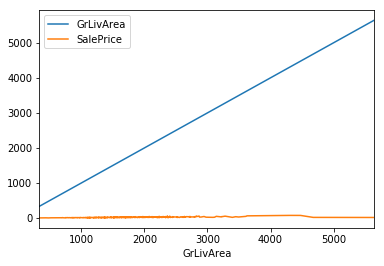

In [60]:
train.groupby('GrLivArea')['GrLivArea','SalePrice'].mean().plot()

In [61]:
# feature_columns.append(tf.feature_column.numeric_column(key='GrLivArea'))

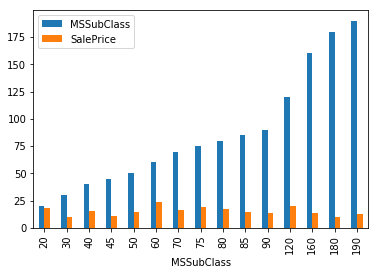

In [62]:
train.groupby('MSSubClass')['MSSubClass','SalePrice'].mean().plot.bar()

In [63]:
# feature_columns.append(tf.feature_column.categorical_column_with_vocabulary_list(key='MSSubClass',vocabulary_list=[20,30,40,45,50,60,70,80,90,120,160,180,190]))

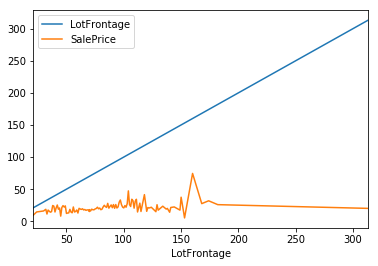

In [64]:
train.groupby('LotFrontage')['LotFrontage','SalePrice'].mean().plot()

In [65]:
# feature_columns.append(tf.feature_column.numeric_column(key='LotFrontage'))

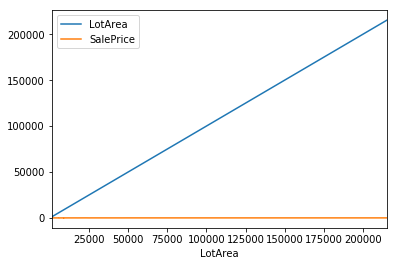

In [66]:
train.groupby('LotArea')['LotArea','SalePrice'].mean().plot()

In [67]:
train_corr.pop('SalePrice')
train_corr

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,TotalBsmtSF,...,BsmtFullBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,Fireplaces,GarageCars,WoodDeckSF,OpenPorchSF,ScreenPorch
MSSubClass,1.000000,-0.357056,-0.139781,0.032628,-0.059316,0.027850,0.040581,0.022895,-0.069836,-0.238518,...,0.003491,0.131608,0.177354,-0.023438,0.281721,-0.045569,-0.040110,-0.012579,-0.006100,-0.026030
LotFrontage,-0.357056,1.000000,0.306795,0.234196,-0.052820,0.117598,0.082746,0.179283,0.215828,0.363358,...,0.091481,0.180424,0.048258,0.237023,-0.005805,0.235755,0.269729,0.077106,0.137454,0.037684
LotArea,-0.139781,0.306795,1.000000,0.105806,-0.005636,0.014228,0.013788,0.103960,0.214103,0.260833,...,0.158155,0.126031,0.014259,0.119690,-0.017784,0.271364,0.154871,0.171698,0.084774,0.043160
OverallQual,0.032628,0.234196,0.105806,1.000000,-0.091932,0.572323,0.550684,0.410238,0.239666,0.537808,...,0.111098,0.550600,0.273458,0.101676,-0.183882,0.396765,0.600671,0.238923,0.308819,0.064886
OverallCond,-0.059316,-0.052820,-0.005636,-0.091932,1.000000,-0.375983,0.073741,-0.127788,-0.046231,-0.171098,...,-0.054942,-0.194149,-0.060769,0.012980,-0.087001,-0.023820,-0.185758,-0.003334,-0.032589,0.054811
YearBuilt,0.027850,0.117598,0.014228,0.572323,-0.375983,1.000000,0.592855,0.314745,0.249503,0.391452,...,0.187599,0.468271,0.242656,-0.070651,-0.174800,0.147716,0.537850,0.224880,0.188686,-0.050364
YearRemodAdd,0.040581,0.082746,0.013788,0.550684,0.073741,0.592855,1.000000,0.179186,0.128451,0.291066,...,0.119470,0.439046,0.183331,-0.040581,-0.149598,0.112581,0.420622,0.205726,0.226298,-0.038740
MasVnrArea,0.022895,0.179283,0.103960,0.410238,-0.127788,0.314745,0.179186,1.000000,0.263582,0.362452,...,0.085055,0.275730,0.200802,0.102417,-0.037364,0.247906,0.363778,0.159349,0.124965,0.061453
BsmtFinSF1,-0.069836,0.215828,0.214103,0.239666,-0.046231,0.249503,0.128451,0.263582,1.000000,0.522396,...,0.649212,0.058543,0.004262,-0.107355,-0.081007,0.260011,0.224054,0.204306,0.111761,0.062021
TotalBsmtSF,-0.238518,0.363358,0.260833,0.537808,-0.171098,0.391452,0.291066,0.362452,0.522396,1.000000,...,0.307351,0.323722,-0.048804,0.050450,-0.068901,0.339519,0.434585,0.232019,0.247264,0.084489


In [68]:

col_type = train.dtypes
col_type['ScreenPorch']

dtype('int64')

In [69]:
feature_columns = []
# train.pop('SaleCondition')
train_x,train_y = train,train.pop('SalePrice')
col_type = train_x.dtypes
for col in col_type.index:
    if col_type[col] == 'object':
#         print('1---------------->',col)
        col_value_couns = train[col].value_counts().index.tolist()
        feature_columns.append(tf.feature_column.indicator_column(tf.feature_column.categorical_column_with_vocabulary_list(key=col,vocabulary_list=col_value_couns)))
    else:
#         print('2---------------->',col)
        mean = train_describe[col]['mean']
        std = train_describe[col]['std']
#         print('3---------------->',mean,std)
        feature_columns.append(tf.feature_column.numeric_column(key = col,normalizer_fn=lambda x:(x - mean) / std)) 


In [70]:
feature_columns
# train['BsmtQual'].value_count

[_NumericColumn(key='MSSubClass', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=<function <lambda> at 0x00000248BACD4598>),
 _IndicatorColumn(categorical_column=_VocabularyListCategoricalColumn(key='MSZoning', vocabulary_list=('RL', 'RM', 'FV', 'RH', 'C (all)'), dtype=tf.string, default_value=-1, num_oov_buckets=0)),
 _NumericColumn(key='LotFrontage', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=<function <lambda> at 0x00000248BACD4950>),
 _NumericColumn(key='LotArea', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=<function <lambda> at 0x00000248A3936268>),
 _IndicatorColumn(categorical_column=_VocabularyListCategoricalColumn(key='LotShape', vocabulary_list=('Reg', 'IR1', 'IR2', 'IR3'), dtype=tf.string, default_value=-1, num_oov_buckets=0)),
 _IndicatorColumn(categorical_column=_VocabularyListCategoricalColumn(key='LandContour', vocabulary_list=('Lvl', 'Bnk', 'HLS', 'Low'), dtype=tf.string, default_value=-1, num_oov_buckets=0)),
 _

In [71]:
def model_fn(features,labels,mode,params):
    
    input_layer = tf.feature_column.input_layer(features=features,feature_columns=params['feature_colums'])
    hiddle_unit = params['hiddle_unit']
    for unit in hiddle_unit:
        input_layer = tf.layers.dense(inputs=input_layer, units=unit,activation=tf.nn.relu,
                        kernel_initializer=tf.random_normal_initializer(),
                                      bias_initializer=tf.constant_initializer(1),
                                      kernel_regularizer = tf.contrib.layers.l1_l2_regularizer(0.5,0.5))
    
    out = tf.layers.dense(inputs=input_layer,units=1)
    
    probabilities = tf.squeeze(out,1)
    
    out_loss = tf.losses.mean_squared_error(labels,probabilities)
    
    loss = tf.add(out_loss,tf.losses.get_regularization_loss())
    
    total_loss =tf.to_float( tf.shape(labels)[0]) * loss
    
    if mode == tf.estimator.ModeKeys.PREDICT:
        predictions = {
            'price': out
        }
        return tf.estimator.EstimatorSpec(mode, predictions=predictions)
    
     # 评估 返回准确率
    if mode == tf.estimator.ModeKeys.EVAL:
        # Fixed for #4083
        pre = tf.cast(predictions, tf.float64)
        accuracy = tf.metrics.root_mean_squared_error(labels=labels,predictions=pre,name ='acc_op')
        metrics = {'rmse':accuracy}
#         tf.summary.scalar(accuracy[1])
        return tf.estimator.EstimatorSpec(mode,loss = total_loss,eval_metric_ops = metrics)
    
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer =  tf.train.AdamOptimizer(learning_rate=0.01);
        train_op = optimizer.minimize(loss,tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode,loss=total_loss,train_op = train_op)
         

In [72]:
params = {'feature_colums':feature_columns,
         'hiddle_unit':[50,5]}
house_regress = tf.estimator.Estimator(model_fn=model_fn,model_dir='./model/',params=params)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': './model/', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x00000248A519EDD8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [75]:
house_regress.train(input_fn=tf.estimator.inputs.pandas_input_fn(x = train_x,y=train_y,shuffle=True,batch_size=128,num_epochs=100000),steps=50000)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./model/model.ckpt-30124
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 30124 into ./model/model.ckpt.
INFO:tensorflow:loss = 1212801.9, step = 30124
INFO:tensorflow:global_step/sec: 63.7686
INFO:tensorflow:loss = 1160324.5, step = 30224 (1.569 sec)
INFO:tensorflow:global_step/sec: 84.8802
INFO:tensorflow:loss = 1110378.1, step = 30324 (1.178 sec)
INFO:tensorflow:global_step/sec: 84.7359
INFO:tensorflow:loss = 1061434.2, step = 30424 (1.179 sec)
INFO:tensorflow:global_step/sec: 85.1373
INFO:tensorflow:loss = 1016062.1, step = 30524 (1.176 sec)
INFO:tensorflow:global_step/sec: 85.5353
INFO:tensorflow:loss = 971687.44, step = 30624 (1.169 sec)
INFO:tensorflow:global_step/sec: 85.462
INFO:tensorflow:loss = 929474.6, step =

INFO:tensorflow:loss = 69089.55, step = 38024 (3.929 sec)
INFO:tensorflow:global_step/sec: 31.6082
INFO:tensorflow:loss = 67200.16, step = 38124 (3.164 sec)
INFO:tensorflow:global_step/sec: 33.0535
INFO:tensorflow:loss = 66891.11, step = 38224 (3.025 sec)
INFO:tensorflow:global_step/sec: 32.9047
INFO:tensorflow:loss = 62673.098, step = 38324 (3.039 sec)
INFO:tensorflow:global_step/sec: 46.8236
INFO:tensorflow:loss = 61124.6, step = 38424 (2.136 sec)
INFO:tensorflow:global_step/sec: 76.1329
INFO:tensorflow:loss = 58377.812, step = 38524 (1.312 sec)
INFO:tensorflow:global_step/sec: 62.3729
INFO:tensorflow:loss = 58277.76, step = 38624 (1.603 sec)
INFO:tensorflow:global_step/sec: 30.577
INFO:tensorflow:loss = 54777.16, step = 38724 (3.271 sec)
INFO:tensorflow:global_step/sec: 24.4267
INFO:tensorflow:loss = 52557.35, step = 38824 (4.095 sec)
INFO:tensorflow:global_step/sec: 28.4955
INFO:tensorflow:loss = 50667.0, step = 38924 (3.507 sec)
INFO:tensorflow:global_step/sec: 74.154
INFO:tensorf

INFO:tensorflow:global_step/sec: 86.0519
INFO:tensorflow:loss = 6984.578, step = 46324 (1.162 sec)
INFO:tensorflow:global_step/sec: 84.9525
INFO:tensorflow:loss = 6527.033, step = 46424 (1.177 sec)
INFO:tensorflow:global_step/sec: 85.9037
INFO:tensorflow:loss = 6390.3154, step = 46524 (1.165 sec)
INFO:tensorflow:global_step/sec: 85.8298
INFO:tensorflow:loss = 5361.5176, step = 46624 (1.163 sec)
INFO:tensorflow:global_step/sec: 86.0519
INFO:tensorflow:loss = 6451.8516, step = 46724 (1.163 sec)
INFO:tensorflow:global_step/sec: 86.2752
INFO:tensorflow:loss = 6733.8, step = 46824 (1.159 sec)
INFO:tensorflow:global_step/sec: 85.756
INFO:tensorflow:loss = 4430.9263, step = 46924 (1.166 sec)
INFO:tensorflow:global_step/sec: 85.9037
INFO:tensorflow:loss = 7562.3604, step = 47024 (1.164 sec)
INFO:tensorflow:global_step/sec: 85.3888
INFO:tensorflow:loss = 4957.6084, step = 47124 (1.171 sec)
INFO:tensorflow:global_step/sec: 85.8297
INFO:tensorflow:loss = 4495.8276, step = 47224 (1.165 sec)
INFO:t

INFO:tensorflow:global_step/sec: 83.8102
INFO:tensorflow:loss = 6789.1104, step = 54624 (1.193 sec)
INFO:tensorflow:global_step/sec: 84.2349
INFO:tensorflow:loss = 7777.0146, step = 54724 (1.187 sec)
INFO:tensorflow:global_step/sec: 84.1639
INFO:tensorflow:loss = 10228.644, step = 54824 (1.211 sec)
INFO:tensorflow:global_step/sec: 82.0858
INFO:tensorflow:loss = 6587.717, step = 54924 (1.195 sec)
INFO:tensorflow:global_step/sec: 84.3774
INFO:tensorflow:loss = 6158.311, step = 55024 (1.185 sec)
INFO:tensorflow:global_step/sec: 85.3888
INFO:tensorflow:loss = 7610.136, step = 55124 (1.208 sec)
INFO:tensorflow:global_step/sec: 82.425
INFO:tensorflow:loss = 7826.3076, step = 55224 (1.176 sec)
INFO:tensorflow:global_step/sec: 82.3569
INFO:tensorflow:loss = 8710.875, step = 55324 (1.213 sec)
INFO:tensorflow:global_step/sec: 81.283
INFO:tensorflow:loss = 10129.637, step = 55424 (1.231 sec)
INFO:tensorflow:global_step/sec: 83.5294
INFO:tensorflow:loss = 7569.781, step = 55524 (1.197 sec)
INFO:te

INFO:tensorflow:loss = 3118.0198, step = 62824 (1.183 sec)
INFO:tensorflow:global_step/sec: 82.0182
INFO:tensorflow:loss = 3437.803, step = 62924 (1.219 sec)
INFO:tensorflow:global_step/sec: 73.9353
INFO:tensorflow:loss = 2474.7278, step = 63024 (1.354 sec)
INFO:tensorflow:global_step/sec: 84.808
INFO:tensorflow:loss = 3891.1995, step = 63124 (1.180 sec)
INFO:tensorflow:global_step/sec: 85.0249
INFO:tensorflow:loss = 2715.3, step = 63224 (1.175 sec)
INFO:tensorflow:global_step/sec: 83.8102
INFO:tensorflow:loss = 3876.2627, step = 63324 (1.192 sec)
INFO:tensorflow:global_step/sec: 85.8297
INFO:tensorflow:loss = 2462.1558, step = 63424 (1.166 sec)
INFO:tensorflow:global_step/sec: 84.9525
INFO:tensorflow:loss = 2399.3757, step = 63524 (1.177 sec)
INFO:tensorflow:global_step/sec: 85.0974
INFO:tensorflow:loss = 2754.4688, step = 63624 (1.175 sec)
INFO:tensorflow:global_step/sec: 84.5922
INFO:tensorflow:loss = 2396.5823, step = 63724 (1.182 sec)
INFO:tensorflow:global_step/sec: 84.7359
INFO:

INFO:tensorflow:global_step/sec: 85.0974
INFO:tensorflow:loss = 2479.5586, step = 71124 (1.174 sec)
INFO:tensorflow:global_step/sec: 84.664
INFO:tensorflow:loss = 3260.0728, step = 71224 (1.182 sec)
INFO:tensorflow:global_step/sec: 85.3888
INFO:tensorflow:loss = 3613.495, step = 71324 (1.171 sec)
INFO:tensorflow:global_step/sec: 85.3157
INFO:tensorflow:loss = 2568.1304, step = 71424 (1.172 sec)
INFO:tensorflow:global_step/sec: 81.7494
INFO:tensorflow:loss = 2842.1052, step = 71524 (1.223 sec)
INFO:tensorflow:global_step/sec: 85.0974
INFO:tensorflow:loss = 2288.8425, step = 71624 (1.175 sec)
INFO:tensorflow:global_step/sec: 85.462
INFO:tensorflow:loss = 2314.4087, step = 71724 (1.169 sec)
INFO:tensorflow:global_step/sec: 84.9525
INFO:tensorflow:loss = 2840.9207, step = 71824 (1.178 sec)
INFO:tensorflow:global_step/sec: 85.3888
INFO:tensorflow:loss = 2558.465, step = 71924 (1.171 sec)
INFO:tensorflow:global_step/sec: 84.5922
INFO:tensorflow:loss = 2659.152, step = 72024 (1.182 sec)
INFO:

INFO:tensorflow:global_step/sec: 80.6552
INFO:tensorflow:loss = 2464.5806, step = 79324 (1.240 sec)
INFO:tensorflow:global_step/sec: 84.0929
INFO:tensorflow:loss = 3225.1987, step = 79424 (1.189 sec)
INFO:tensorflow:global_step/sec: 84.3062
INFO:tensorflow:loss = 3252.8352, step = 79524 (1.186 sec)
INFO:tensorflow:global_step/sec: 83.8102
INFO:tensorflow:loss = 2475.1614, step = 79624 (1.193 sec)
INFO:tensorflow:global_step/sec: 83.9514
INFO:tensorflow:loss = 2821.5208, step = 79724 (1.191 sec)
INFO:tensorflow:global_step/sec: 84.3774
INFO:tensorflow:loss = 2285.5872, step = 79824 (1.185 sec)
INFO:tensorflow:global_step/sec: 83.9514
INFO:tensorflow:loss = 3071.8926, step = 79924 (1.191 sec)
INFO:tensorflow:global_step/sec: 82.7669
INFO:tensorflow:loss = 2725.9177, step = 80024 (1.208 sec)
INFO:tensorflow:Saving checkpoints for 80124 into ./model/model.ckpt.
INFO:tensorflow:Loss for final step: 2611.273.
